## Requisitos

In [23]:
!pip install tensorflow
!pip install tensorflow-gpu
!pip install nvidia-cudnn-cu12
!pip install Pillow
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tf-explain
!pip install opencv-python
!pip install rembg
!pip install onnxruntime

# Rodar um 
# conda install -c conda-forge cudatoolkit

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/requirements.py", line 36, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/_parser.py", line 62, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/packaging/_parser.py", line 80, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/home/vinmelo/Documents/Deep-

## Carregando os dados

### Data Augmentation

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    samplewise_center=True,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2,
    horizontal_flip = True,
    vertical_flip = False
)
datagen_valid = ImageDataGenerator(
    samplewise_center=True,
    validation_split=0.2
)

2025-07-10 22:36:59.691077: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 22:36:59.885705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752197819.930453   43934 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752197819.941845   43934 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752197819.961669   43934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Para avaliar os diferentes tipos de filtro, vamos carregar o data set de 7 formas:
- Variando cada crop com uma técnica de filtro
- Crop sem background

In [3]:
dir_used = ["crop_and_laplacian","crop_and_canny","crop_and_clahe","crop_and_scharr","crop_and_sharpening","crop_only", "removed_bg"]

train_dt = [datagen_train.flow_from_directory(
    f"./images/{dir_used[i]}/proporcional_resize/side",
    subset="training",
    seed=123,
    color_mode="rgb",
    target_size=(224,224),
    class_mode='binary',
) for i in range(7)]

valid_dt = [datagen_valid.flow_from_directory(
    f"./images/{dir_used[i]}/proporcional_resize/side",
    subset="validation",
    seed=123,
    color_mode="rgb",
    target_size=(224,224),
    class_mode='binary',
) for i in range(7)]

Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 142 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


## Modelo para Side
### Importando o Modelo pré treinado

In [4]:
from tensorflow import keras
base_model = keras.applications.EfficientNetB0(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
)

I0000 00:00:1752197834.638363   43934 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1403 MB memory:  -> device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:05:00.0, compute capability: 7.5


Congelando as primeiras camadas para treinarmos apenas as camada finais

In [5]:
base_model.trainable = False

### Adicionando camadas e compilando

In [6]:
inputs = keras.Input(shape=(224,224,3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = keras.layers.Dense(1, activation= 'sigmoid')(x)

models = [keras.Model(inputs,outputs) for i in range(7)]
models

[<Functional name=functional, built=True>,
 <Functional name=functional_1, built=True>,
 <Functional name=functional_2, built=True>,
 <Functional name=functional_3, built=True>,
 <Functional name=functional_4, built=True>,
 <Functional name=functional_5, built=True>,
 <Functional name=functional_6, built=True>]

In [7]:
for i in range(7):
    models[i].compile(loss = 'binary_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

### Treinando o modelo para cada tipo de imagem

In [8]:
for i in range(7):
    models[i].fit(train_dt[i],
          validation_data=valid_dt[i],
          epochs=50)

/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1752197855.902506   45070 service.cc:152] XLA service 0x788abc001e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752197855.902527   45070 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2025-07-10 22:37:36.262096: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752197857.930151   45070 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-07-10 22:37:46.842099: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:37:47.034858: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, plea

3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - AUC: 0.4772 - Precision: 0.4703 - Recall: 0.6704 - accuracy: 0.4740 - loss: 0.7314

2025-07-10 22:38:02.769722: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:38:02.937343: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:38:03.511035: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:38:03.690193: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:38:04.416637: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.4965 - Precision: 0.4853 - Recall: 0.6208 - accuracy: 0.4947 - loss: 0.7214 

2025-07-10 22:38:20.551088: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:38:20.703421: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:38:21.217933: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:38:21.386368: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:38:22.083314: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - AUC: 0.4989 - Precision: 0.4890 - Recall: 0.5937 - accuracy: 0.4967 - loss: 0.7198 - val_AUC: 0.6034 - val_Precision: 0.4839 - val_Recall: 0.8333 - val_accuracy: 0.4722 - val_loss: 0.7005
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - AUC: 0.5291 - Precision: 0.5355 - Recall: 0.5397 - accuracy: 0.5394 - loss: 0.7006 - val_AUC: 0.6157 - val_Precision: 0.4688 - val_Recall: 0.8333 - val_accuracy: 0.4444 - val_loss: 0.6963
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - AUC: 0.6388 - Precision: 0.6184 - Recall: 0.6767 - accuracy: 0.6287 - loss: 0.6648 - val_AUC: 0.6420 - val_Precision: 0.4839 - val_Recall: 0.8333 - val_accuracy: 0.4722 - val_loss: 0.6881
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - AUC: 0.5998 - Precision: 0.5767 - Recall: 0.6186 - accuracy: 0.5703 - loss: 0.6780 - val_AUC: 0.6682 - val_Precision: 0.6500 - val_Recall: 0.7222 - val_accuracy: 0.6667 - val_loss: 0.6734
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - A

2025-07-10 22:49:45.289802: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:49:45.453884: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:49:46.022466: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:49:46.202585: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:49:46.948553: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9755 - Precision: 0.9404 - Recall: 0.8868 - accuracy: 0.9219 - loss: 0.2049

2025-07-10 22:50:11.442995: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:50:11.594424: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:50:12.089214: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:50:12.259094: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-10 22:50:12.948448: E external/local_xla/xla/stream_

5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - AUC: 0.9719 - Precision: 0.9313 - Recall: 0.8825 - accuracy: 0.9138 - loss: 0.2188 - val_AUC: 0.9412 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.8571 - val_loss: 0.3351
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - AUC: 0.9398 - Precision: 0.8252 - Recall: 0.9004 - accuracy: 0.8545 - loss: 0.3275 - val_AUC: 0.9428 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.8571 - val_loss: 0.3317
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - AUC: 0.9281 - Precision: 0.8647 - Recall: 0.8762 - accuracy: 0.8677 - loss: 0.3415 - val_AUC: 0.9477 - val_Precision: 0.8095 - val_Recall: 0.9444 - val_accuracy: 0.8571 - val_loss: 0.3216
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - AUC: 0.9302 - Precision: 0.8599 - Recall: 0.8571 - accuracy: 0.8629 - loss: 0.3606 - val_AUC: 0.9493 - val_Precision: 0.8500 - val_Recall: 0.9444 - val_accuracy: 0.8857 - val_loss: 0.3088
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - A

### Avaliando os modelos

#### Acurácia

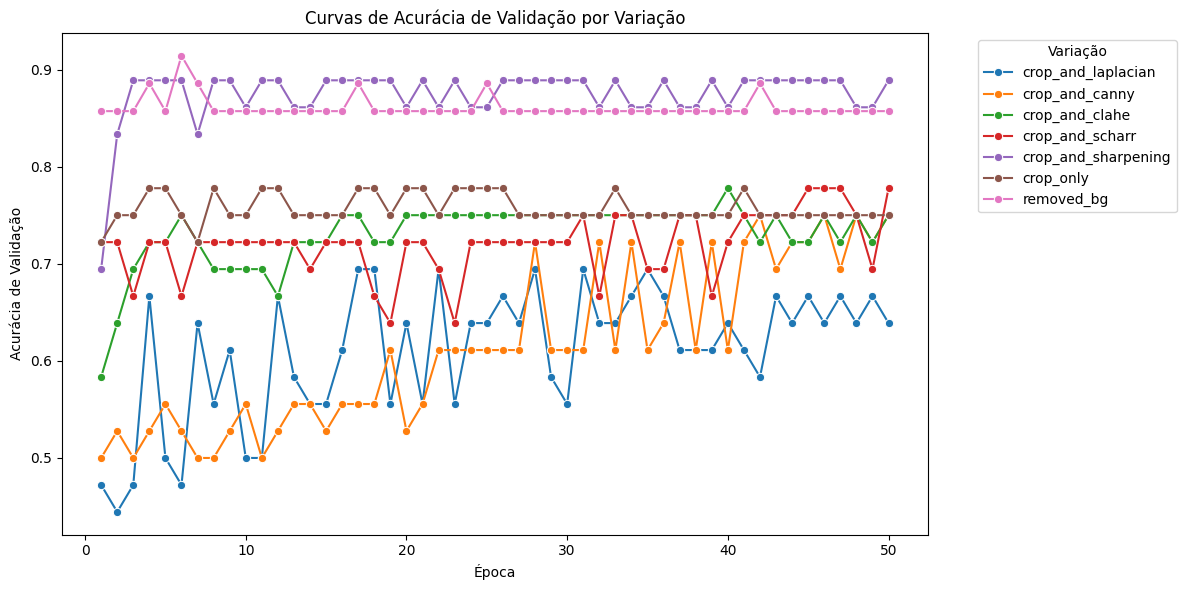

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_accuracy']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### AUC (Area under the curve)

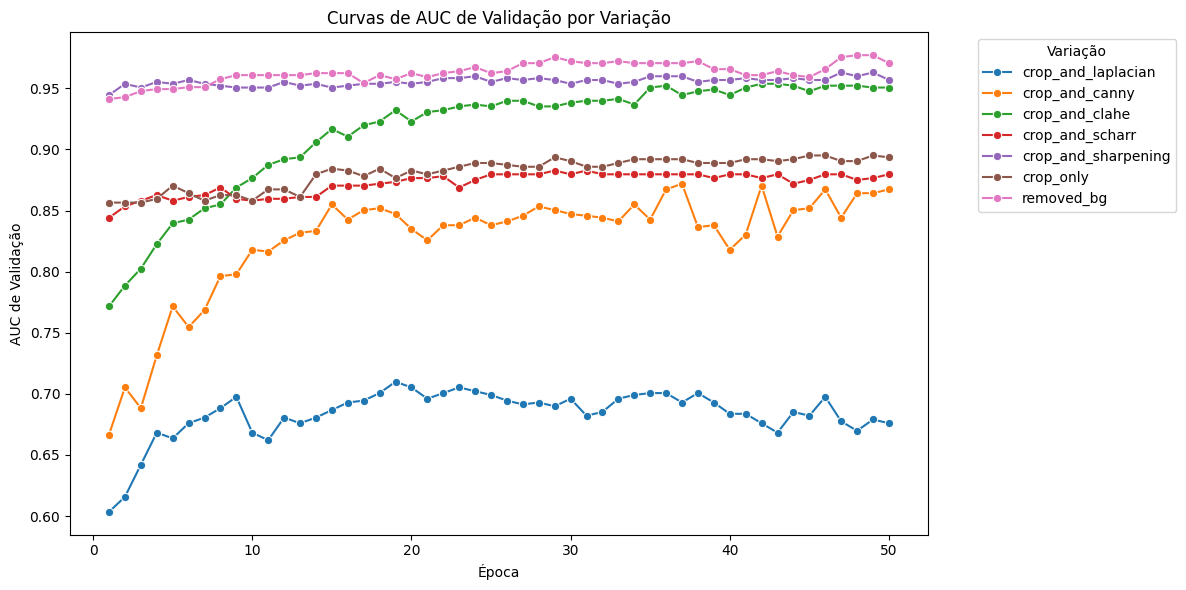

In [11]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_AUC']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de AUC de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("AUC de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Precision

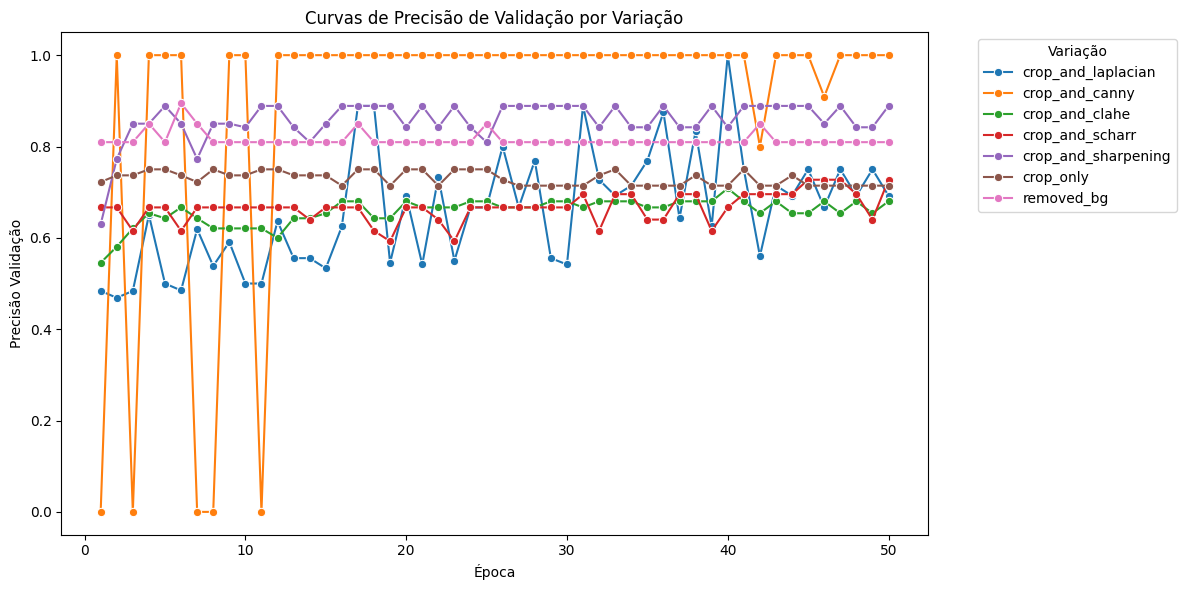

In [12]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_Precision']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Precisão de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Precisão Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Recall

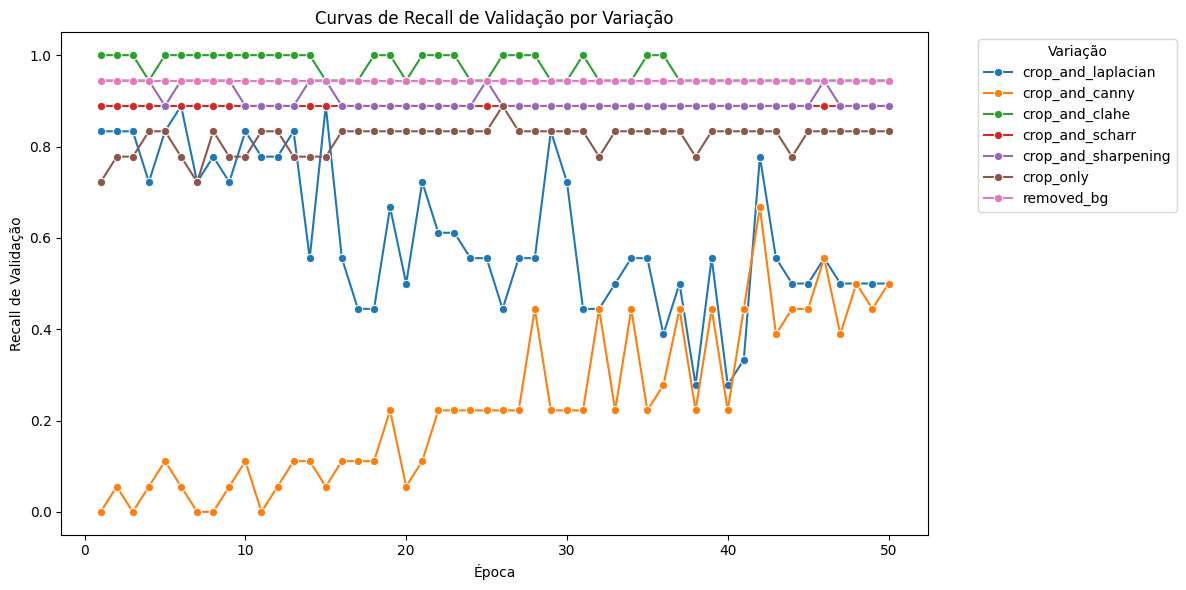

In [13]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_Recall']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Recall de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Recall de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

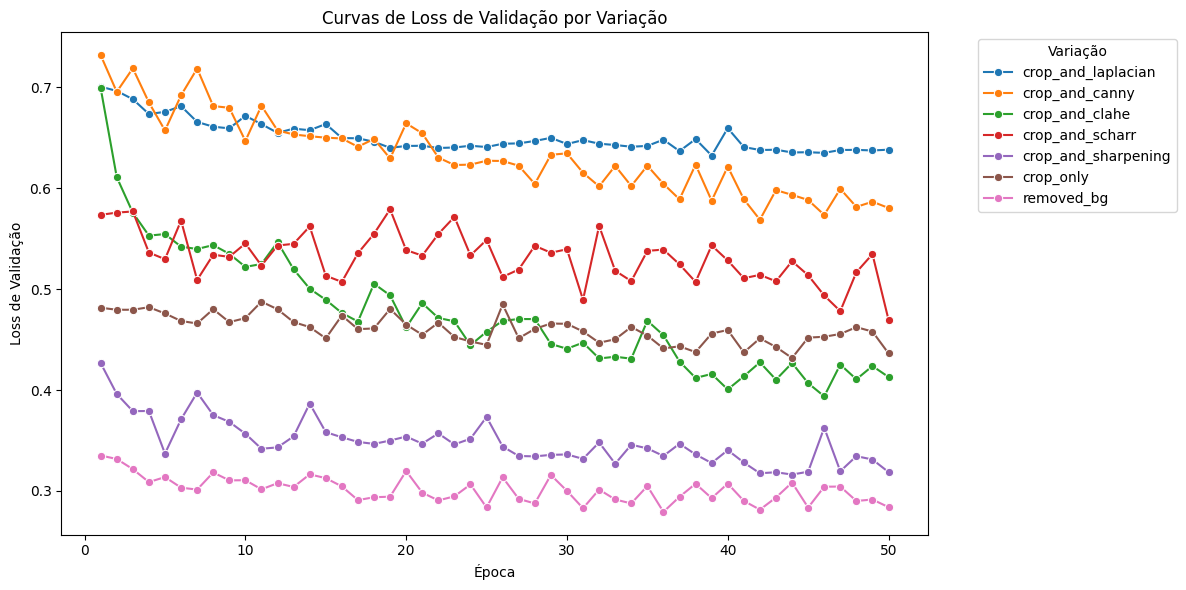

In [14]:
data = []

for model, name in zip(models, dir_used):
    val_accuracies = model.history.history['val_loss']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Loss de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Loss de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [35]:
models[4].history.history['val_accuracy'][-1]
models[4].save('side-transfer.keras')
models[6].save('side-teste.keras')

#### Matriz de confusão

Como o modelo funcionou melhor com crop_and_sharpening, vamos fazer a matriz de confusão
apenas com esse pré processamento

In [34]:
models[4].save('transfer-learning_side.keras')

## Modelo para top

### Importando o modelo VGG16

In [4]:
from tensorflow import keras

base_model_top = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224,224,3),
    include_top=False
)

base_model_top.trainable = False

I0000 00:00:1752166622.165980   81431 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1403 MB memory:  -> device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:05:00.0, compute capability: 7.5


### Adicionando camadas e compilando

In [5]:
inputs_top = keras.Input(shape=(224,224,3))

x_top = base_model_top(inputs_top, training=False)
x_top = keras.layers.GlobalAveragePooling2D()(x_top)

outputs_top = keras.layers.Dense(1, activation= 'sigmoid')(x_top)

models_top = [keras.Model(inputs_top,outputs_top) for i in range(7)]
models_top

[<Functional name=functional, built=True>,
 <Functional name=functional_1, built=True>,
 <Functional name=functional_2, built=True>,
 <Functional name=functional_3, built=True>,
 <Functional name=functional_4, built=True>,
 <Functional name=functional_5, built=True>,
 <Functional name=functional_6, built=True>]

In [6]:
for i in range(7):
    models_top[i].compile(loss = 'binary_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

### Treinando o modelo

In [9]:
for i in range(7):
    models_top[i].fit(train_dt[i],
              validation_data=valid_dt[i],
              epochs=50)

/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1752166822.912173   82238 service.cc:152] XLA service 0x7009dc00df50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752166822.912197   82238 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2025-07-10 14:00:22.964957: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752166823.333017   82238 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-07-10 14:00:24.354704: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.1458, f32[64,3,3,3]{3,2,1,0} %bitcast.1465, f32[64]{0} %bitcast.1467), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - AUC: 0.5562 - Precision: 0.5306 - Recall: 0.9173 - accuracy: 0.5280 - loss: 3.2005

2025-07-10 14:00:48.706124: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0} %bitcast.1458, f32[64,3,3,3]{3,2,1,0} %bitcast.1465, f32[64]{0} %bitcast.1467), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-10 14:00:48.934098: I external/local_xla/xla/service/

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.5556 - Precision: 0.5245 - Recall: 0.8894 - accuracy: 0.5224 - loss: 3.0291   

2025-07-10 14:01:05.605815: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[4,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,3,224,224]{3,2,1,0} %bitcast.1203, f32[64,3,3,3]{3,2,1,0} %bitcast.1210, f32[64]{0} %bitcast.1212), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-10 14:01:06.084449: I external/local_xla/xla/service/gp

5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - AUC: 0.5551 - Precision: 0.5204 - Recall: 0.8708 - accuracy: 0.5187 - loss: 2.9148 - val_AUC: 0.5540 - val_Precision: 0.5385 - val_Recall: 0.7778 - val_accuracy: 0.5556 - val_loss: 1.3341
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 589ms/step - AUC: 0.5252 - Precision: 0.5188 - Recall: 0.4894 - accuracy: 0.5392 - loss: 1.4006 - val_AUC: 0.5772 - val_Precision: 0.5517 - val_Recall: 0.8889 - val_accuracy: 0.5833 - val_loss: 1.3926
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - AUC: 0.6398 - Precision: 0.5784 - Recall: 0.6072 - accuracy: 0.5848 - loss: 1.0434 - val_AUC: 0.6096 - val_Precision: 0.5517 - val_Recall: 0.8889 - val_accuracy: 0.5833 - val_loss: 1.3431
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 598ms/step - AUC: 0.6385 - Precision: 0.5801 - Recall: 0.6341 - accuracy: 0.5787 - loss: 1.0283 - val_AUC: 0.6343 - val_Precision: 0.5769 - val_Recall: 0.8333 - val_accuracy: 0.6111 - val_loss: 1.0787
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 584ms/step - A

2025-07-10 14:17:59.597123: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[14,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,3,224,224]{3,2,1,0} %bitcast.1458, f32[64,3,3,3]{3,2,1,0} %bitcast.1465, f32[64]{0} %bitcast.1467), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/vgg16_1/block1_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-10 14:17:59.839186: I external/local_xla/xla/servic

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - AUC: 0.8925 - Precision: 0.8747 - Recall: 0.7129 - accuracy: 0.8159 - loss: 0.4759 

2025-07-10 14:18:25.539338: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.46 = (f32[3,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,256,28,28]{3,2,1,0} %bitcast.1305, f32[512,256,3,3]{3,2,1,0} %bitcast.1312, f32[512]{0} %bitcast.1314), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/vgg16_1/block4_conv1_1/convolution" source_file="/home/vinmelo/Documents/Deep-Learning-Package-Inspection/.venv/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-10 14:18:27.489632: I external/local_xla/xla/servi

5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - AUC: 0.8978 - Precision: 0.8759 - Recall: 0.7330 - accuracy: 0.8231 - loss: 0.4590 - val_AUC: 0.9069 - val_Precision: 0.7083 - val_Recall: 0.9444 - val_accuracy: 0.7714 - val_loss: 0.5100
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 993ms/step - AUC: 0.9050 - Precision: 0.8123 - Recall: 0.8657 - accuracy: 0.8242 - loss: 0.4127 - val_AUC: 0.9150 - val_Precision: 0.7391 - val_Recall: 0.9444 - val_accuracy: 0.8000 - val_loss: 0.4469
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step - AUC: 0.9237 - Precision: 0.8046 - Recall: 0.8670 - accuracy: 0.8278 - loss: 0.3780 - val_AUC: 0.9167 - val_Precision: 0.7391 - val_Recall: 0.9444 - val_accuracy: 0.8000 - val_loss: 0.4564
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 610ms/step - AUC: 0.9259 - Precision: 0.8450 - Recall: 0.8383 - accuracy: 0.8365 - loss: 0.3641 - val_AUC: 0.9248 - val_Precision: 0.8947 - val_Recall: 0.9444 - val_accuracy: 0.9143 - val_loss: 0.3851
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step - A

### Acurácia

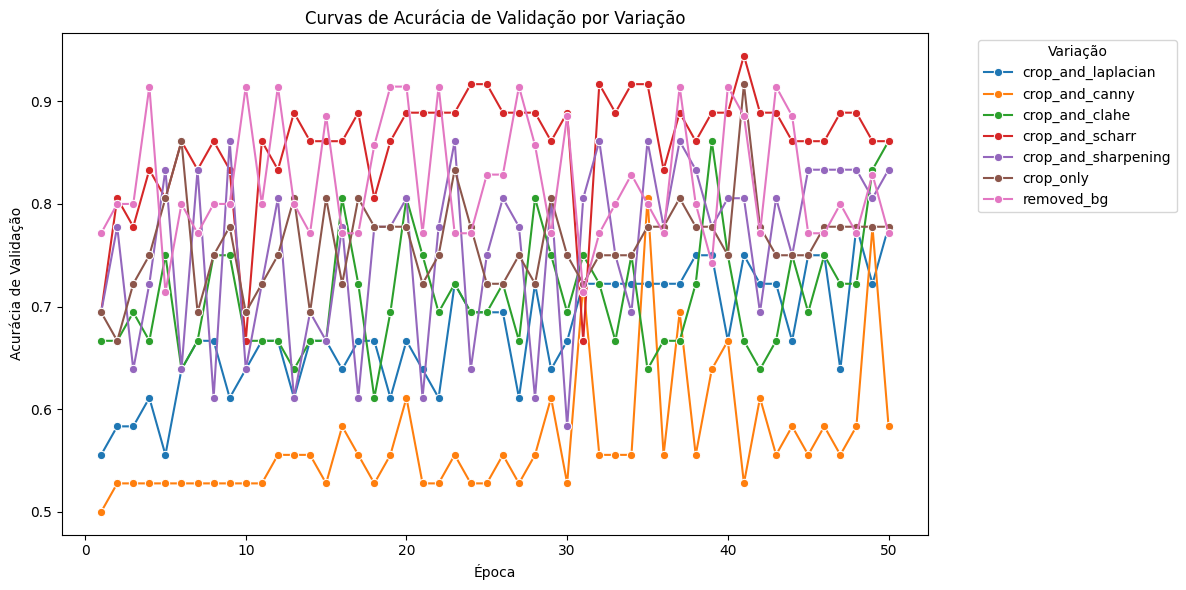

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_accuracy']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### AUC

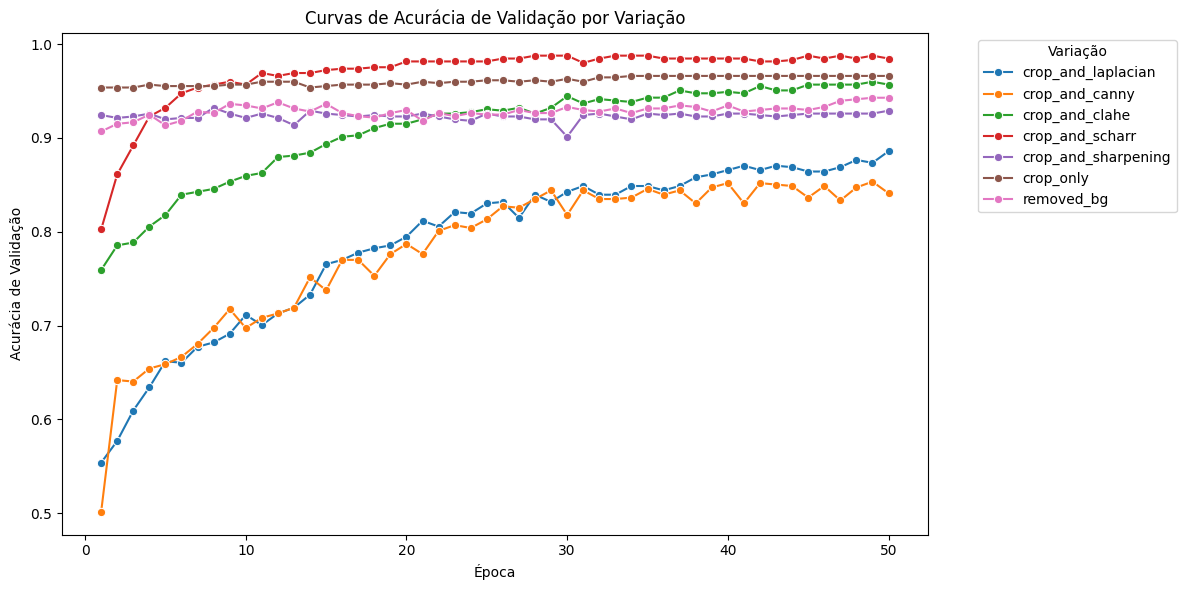

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_AUC']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Acurácia de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Acurácia de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Precision

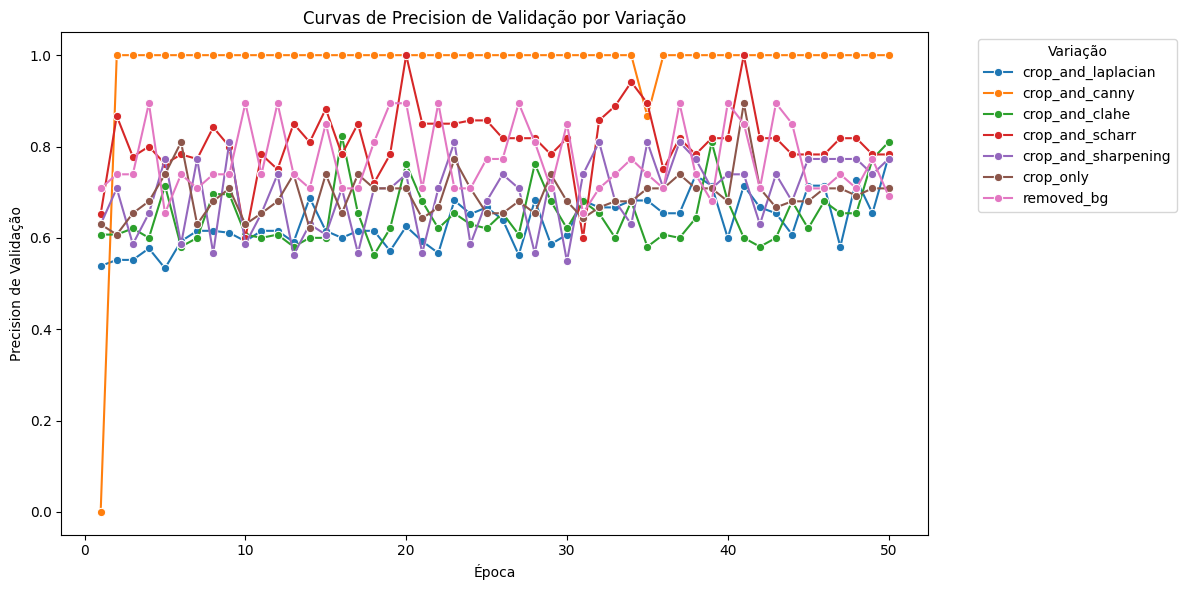

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_Precision']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Precision de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Precision de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Recall

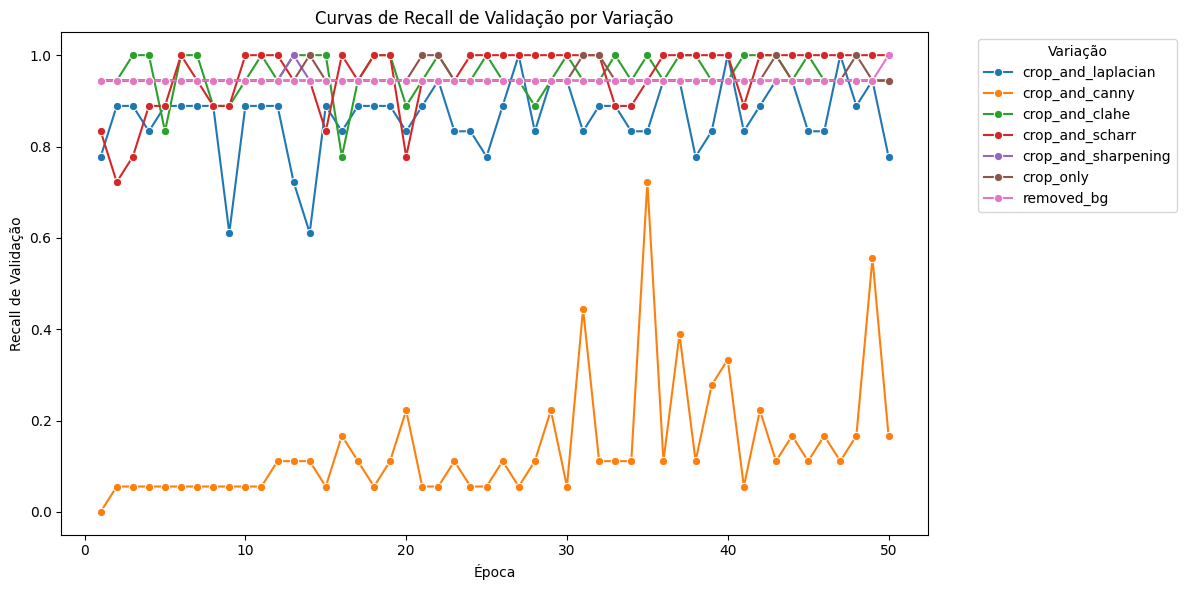

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Constrói uma tabela com: época, acurácia, nome da variação
data = []

for model, name in zip(models_top, dir_used):
    val_accuracies = model.history.history['val_Recall']
    for epoch, acc in enumerate(val_accuracies):
        data.append({
            'Epoch': epoch + 1,
            'Val_Accuracy': acc,
            'Variação': name
        })

# Cria um DataFrame para usar com seaborn
df = pd.DataFrame(data)

# Faz o plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Epoch', y='Val_Accuracy', hue='Variação', marker='o')

plt.title("Curvas de Recall de Validação por Variação")
plt.xlabel("Época")
plt.ylabel("Recall de Validação")
plt.legend(title="Variação", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
models_top[3].save('transfer-learning_top.keras')

## Interpretabilidade

Pré processamento da imagem de teste

In [29]:
import cv2
import numpy as np
from PIL import Image

def apply_sharpening(input_path: str, output_path: str):
    try:
        # Lê a imagem de entrada
        image = crop_box_and_return_image(input_path)
        if image is None:
            print(f"  [ERRO] Não foi possível ler o arquivo: {input_path}")
            return False

        # Define o kernel de nitidez com o valor fixo de 8.5
        sharpening_kernel = np.array([
            [-1, -1, -1],
            [-1, 8.5, -1],
            [-1, -1, -1]
        ], dtype=np.float32)

        # Aplica o filtro de convolução
        sharpened_image = cv2.filter2D(image, -1, sharpening_kernel)
        
        # Salva a imagem resultante
        cv2.imwrite(output_path, sharpened_image)
        return True

    except Exception as e:
        print(f"  [ERRO] Ocorreu uma exceção ao processar '{input_path}': {e}")
        return False
    
def proportional_resize_with_padding(input_path: str, output_path: str, canvas_size: tuple = (244, 244)):
    try:
        # Abre a imagem original
        original_img = Image.open(input_path)

        # Garante que a imagem esteja em modo RGB, tratando a transparência
        rgb_img = Image.new("RGB", original_img.size, (0, 0, 0))
        rgb_img.paste(original_img, mask=original_img.getchannel('A') if original_img.mode == 'RGBA' else None)

        # Calcula a proporção para o novo tamanho sem distorcer
        ratio = min((canvas_size[0] / rgb_img.width), (canvas_size[1] / rgb_img.height))
        new_width = int(rgb_img.width * ratio)
        new_height = int(rgb_img.height * ratio)

        # Redimensiona a imagem mantendo a proporção
        resized_img = rgb_img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        # Cria o canvas final com fundo preto
        black_canvas = Image.new('RGB', canvas_size, (0, 0, 0))

        # Calcula a posição para colar a imagem redimensionada no centro do canvas
        paste_x = (canvas_size[0] - new_width) // 2
        paste_y = (canvas_size[1] - new_height) // 2

        # Cola a imagem redimensionada no canvas
        black_canvas.paste(resized_img, (paste_x, paste_y))

        # Salva a imagem final
        black_canvas.save(output_path)
        print(f"Imagem redimensionada (proporcional) e salva em: {output_path}")

    except FileNotFoundError:
        print(f"Erro: O arquivo de entrada não foi encontrado em '{input_path}'")
        input()
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        input()

def crop_box_and_return_image(image_path):
    """
    Processa uma única imagem e retorna o objeto da imagem recortada, ou None se falhar.
    """
    
    MARGEM_X = 15
    MARGEM_Y = 15
    BLUR_KERNEL = 5
    CONTRASTE_ALPHA = 1.2
    BRILHO_BETA = -50
    SATURACAO_FACTOR = 2.4
    MORPH_KERNEL = 7
    MORPH_ITERATIONS = 0
    LOWER_CYAN = np.array([48, 0, 100])
    UPPER_CYAN = np.array([104, 255, 255])
    LOWER_WHITE = np.array([0, 0, 160])
    UPPER_WHITE = np.array([176, 60, 255])

    image = cv2.imread(image_path)
    if image is None:
        print(f"  [ERRO] Não foi possível carregar a imagem: {image_path}")
        return None

    img_h, img_w = image.shape[:2]

    # --- Pipeline de Processamento ---
    processed_image = image.copy()
    if BLUR_KERNEL > 1:
        processed_image = cv2.GaussianBlur(processed_image, (BLUR_KERNEL, BLUR_KERNEL), 0)
    processed_image = cv2.convertScaleAbs(processed_image, alpha=CONTRASTE_ALPHA, beta=BRILHO_BETA)
    hsv_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    s = np.clip(s * SATURACAO_FACTOR, 0, 255).astype(np.uint8)
    final_hsv = cv2.merge([h, s, v])
    mask_cyan = cv2.inRange(final_hsv, LOWER_CYAN, UPPER_CYAN)
    mask_white = cv2.inRange(final_hsv, LOWER_WHITE, UPPER_WHITE)
    final_mask = cv2.bitwise_or(mask_cyan, mask_white)

    if MORPH_KERNEL > 1 and MORPH_ITERATIONS > 0:
        kernel = np.ones((MORPH_KERNEL, MORPH_KERNEL), np.uint8)
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, kernel, iterations=MORPH_ITERATIONS)
    
    # --- Encontrar e Recortar o Contorno ---
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"  [AVISO] Nenhum contorno encontrado para: {os.path.basename(image_path)}")
        return None
        
    final_contour = max(contours, key=cv2.contourArea)

    # --- Calcular Bounding Box e Adicionar Margem ---
    x, y, w, h = cv2.boundingRect(final_contour)
    x_start = max(0, x - MARGEM_X)
    y_start = max(0, y - MARGEM_Y)
    x_end = min(img_w, x + w + MARGEM_X)
    y_end = min(img_h, y + h + MARGEM_Y)
    
    # Retorna a imagem recortada
    return image[y_start:y_end, x_start:x_end]

Ocorreu um erro: name 'Image' is not defined


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


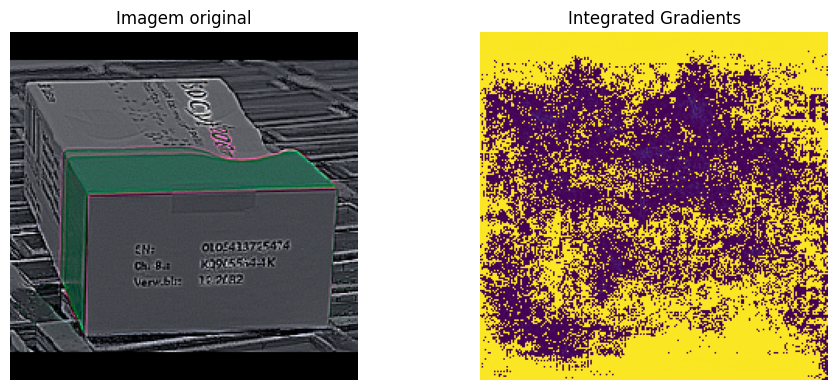

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tf_explain.core.integrated_gradients import IntegratedGradients

# 1. Pré-processamento da imagem
img_path = "dataset-desafio/interpretabilidade/damaged/side/0105413725474_side.png"

apply_sharpening(img_path, "test.png")
proportional_resize_with_padding("test.png", "resize_test.png")

img = load_img("resize_test.png", target_size=(224, 224))
img_array = img_to_array(img)

# Aplicar samplewise_center, igual no seu generator
img_array -= np.mean(img_array, keepdims=True)
img_array = np.expand_dims(img_array, axis=0)

# 2. Carregar o modelo
model_side = models[4]  # Ou load_model("seu_modelo.keras")
pred = model_side.predict(img_array)
class_index = np.argmax(pred)

# 3. Criar o explicador Integrated Gradients
explainer = IntegratedGradients()

# 4. Executar a explicação
explanation = explainer.explain((img_array, None), model_side, class_index=class_index)

# 5. Mostrar resultados

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Imagem original")
plt.imshow(np.array(img).astype(np.uint8))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Integrated Gradients")
plt.imshow(explanation)
plt.axis("off")

plt.tight_layout()
plt.show()


In [26]:
from rembg import new_session, remove

def remove_background(
    image_path: str,
    output_filename: str,
    padding: int = 30
):
    """
    Carrega uma imagem de um caminho,
    aplica o processo refinado de remoção de fundo e salva o resultado.
    """
    # Carrega a imagem a partir do caminho
    input_image = crop_box_and_return_image(image_path)
    if input_image is None:
        print(f"    [ERRO] Não foi possível carregar a imagem: {image_path}")
        return

    h_orig, w_orig = input_image.shape[:2]
    session = new_session("isnet-general-use")

    # --- Motor de Detecção (Passos 1-4) ---
    mask_pass1 = remove(input_image, session=session, only_mask=True)
    lab_clahe = cv2.cvtColor(input_image, cv2.COLOR_BGR2LAB)
    l_clahe, a_clahe, b_clahe = cv2.split(lab_clahe)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(2, 2))
    cl = clahe.apply(l_clahe)
    merged_lab_clahe = cv2.merge([cl, a_clahe, b_clahe])
    enhanced_image_clahe = cv2.cvtColor(merged_lab_clahe, cv2.COLOR_LAB2BGR)
    mask_pass2 = remove(enhanced_image_clahe, session=session, only_mask=True)
    lab_bright = cv2.cvtColor(input_image, cv2.COLOR_BGR2LAB)
    l_bright, a_bright, b_bright = cv2.split(lab_bright)
    l_boosted = np.where(cv2.inRange(l_bright, 180, 255) == 255, 255, l_bright)
    merged_lab_bright = cv2.merge([l_boosted, a_bright, b_bright])
    enhanced_image_bright = cv2.cvtColor(merged_lab_bright, cv2.COLOR_LAB2BGR)
    mask_pass3 = remove(enhanced_image_bright, session=session, only_mask=True)
    hls = cv2.cvtColor(input_image, cv2.COLOR_BGR2HLS)
    mask_pass4 = cv2.inRange(hls, np.array([0, 180, 0]), np.array([255, 255, 40]))

    # --- Combinação e Calibração Final (Passo 5) ---
    combined_mask_ia = cv2.bitwise_or(cv2.bitwise_or(mask_pass1, mask_pass2), mask_pass3)
    final_combined_mask = cv2.bitwise_or(combined_mask_ia, mask_pass4)
    dilated_mask = cv2.dilate(final_combined_mask, np.ones((7, 7), np.uint8), iterations=4)

    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"    [ERRO] Nenhum contorno encontrado após dilatação.")
        return

    mask_reconstruida = np.zeros((h_orig, w_orig), dtype=np.uint8)
    significant_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 10]
    for contour in significant_contours:
        cv2.drawContours(mask_reconstruida, [contour], -1, 255, thickness=cv2.FILLED)

    eroded_mask = cv2.erode(mask_reconstruida, np.ones((5, 5), np.uint8), iterations=7)
    mask_final = cv2.dilate(eroded_mask, np.ones((3, 3), np.uint8), iterations=6)

    # --- Aplicar Máscara e Salvar ---
    b, g, r = cv2.split(input_image)
    final_rgba_image = cv2.merge([b, g, r, mask_final])

    final_contours, _ = cv2.findContours(mask_final, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not final_contours:
        final_cropped_image = final_rgba_image
    else:
        x_coords, y_coords = [], []
        for contour in final_contours:
            x, y, w, h = cv2.boundingRect(contour)
            x_coords.extend([x, x + w])
            y_coords.extend([y, y + h])

        x_start = max(0, min(x_coords) - padding)
        y_start = max(0, min(y_coords) - padding)
        x_end = min(w_orig, max(x_coords) + padding)
        y_end = min(h_orig, max(y_coords) + padding)
        final_cropped_image = final_rgba_image[y_start:y_end, x_start:x_end]

    cv2.imwrite(output_filename, final_cropped_image)
    print(f"  -> Sucesso! Resultado final salvo.")

  -> Sucesso! Resultado final salvo.
Imagem redimensionada (proporcional) e salva em: resize_test.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


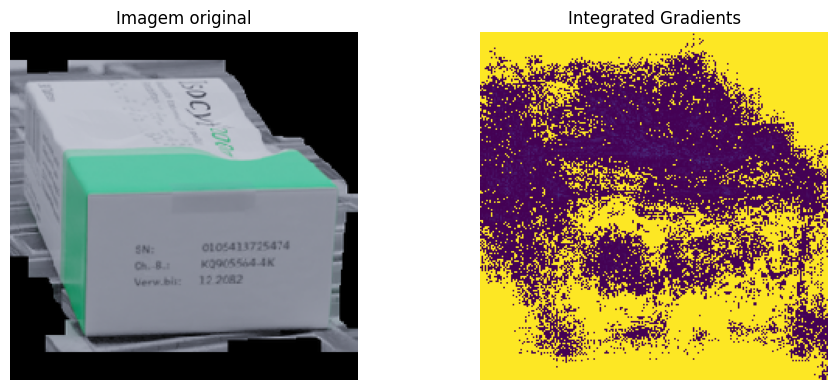

In [30]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tf_explain.core.integrated_gradients import IntegratedGradients

# 1. Pré-processamento da imagem
img_path = "dataset-desafio/interpretabilidade/damaged/side/0105413725474_side.png"

remove_background(img_path, "test.png")
proportional_resize_with_padding("test.png", "resize_test.png")

img = load_img("resize_test.png", target_size=(224, 224))
img_array = img_to_array(img)

# Aplicar samplewise_center, igual no seu generator
img_array -= np.mean(img_array, keepdims=True)
img_array = np.expand_dims(img_array, axis=0)

# 2. Carregar o modelo
model_side = models[6]  # Ou load_model("seu_modelo.keras")
pred = model_side.predict(img_array)
class_index = np.argmax(pred)

# 3. Criar o explicador Integrated Gradients
explainer = IntegratedGradients()

# 4. Executar a explicação
explanation = explainer.explain((img_array, None), model_side, class_index=class_index)

# 5. Mostrar resultados

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Imagem original")
plt.imshow(np.array(img).astype(np.uint8))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Integrated Gradients")
plt.imshow(explanation)
plt.axis("off")

plt.tight_layout()
plt.show()
